In [1]:
import os

import altair as vg
import pandas as pd
from IPython.display import display, Markdown

from meli.common import get_base_path
from meli.visualization.bar import bar, histogram
from meli.visualization.line import regplot
from meli.visualization.common import configure_title

In [2]:
PROBLEM = 'cpi'

base_path = get_base_path()
raw_data_path = os.path.join(base_path, 'data/raw')
data_path = os.path.join(base_path, f'data/{PROBLEM}')

# Data Loading and Exploration

1. Both series are normalized to start at 100.
2. Updates:
    - CPI Changes on the 1st of each month;
    - PriceStats is updated daily.
    - For both series, the change is measuared as the ratio of the values measured on each date, i.e. $Change(Series, t1, t2) = \frac{Series(t2)}{Series(t1)}$
3. Null Values:
    - PriceStats has no empty values;
    - CPI is null for the last 35 days of the sample;
    
Before diving into modeling, we split data by creating a hold out period consisting of the last couple of years. So as not to cherry-pick any dates (as this is past data for US inflation, we may have preconceptions), we pick 30% of the available days as hold-out.

In [3]:
data = pd.read_csv(os.path.join(raw_data_path, 'PriceStats_CPI.csv'))
data.head(15)

date  PriceStats       CPI
0   2008-07-24   100.00000  100.0000
1   2008-07-25    99.99767  100.0000
2   2008-07-26    99.92376  100.0000
3   2008-07-27    99.91537  100.0000
4   2008-07-28    99.89491  100.0000
5   2008-07-29    99.88470  100.0000
6   2008-07-30    99.88448  100.0000
7   2008-07-31    99.86741  100.0000
8   2008-08-01    99.85761  100.5251
9   2008-08-02    99.85294  100.5251
10  2008-08-03    99.83906  100.5251
11  2008-08-04    99.82535  100.5251
12  2008-08-05    99.82465  100.5251
13  2008-08-06    99.83427  100.5251
14  2008-08-07    99.81851  100.5251

In [4]:
data.isna().sum()

date           0
PriceStats     0
CPI           35
dtype: int64

In [5]:
data.tail(35)

date  PriceStats  CPI
4087  2019-10-02    118.1786  NaN
4088  2019-10-03    118.1983  NaN
4089  2019-10-04    118.2018  NaN
4090  2019-10-05    118.1861  NaN
4091  2019-10-06    118.1780  NaN
4092  2019-10-07    118.1774  NaN
4093  2019-10-08    118.1781  NaN
4094  2019-10-09    118.1882  NaN
4095  2019-10-10    118.1804  NaN
4096  2019-10-11    118.1728  NaN
4097  2019-10-12    118.1702  NaN
4098  2019-10-13    118.1690  NaN
4099  2019-10-14    118.1700  NaN
4100  2019-10-15    118.1690  NaN
4101  2019-10-16    118.2087  NaN
4102  2019-10-17    118.2398  NaN
4103  2019-10-18    118.2324  NaN
4104  2019-10-19    118.2391  NaN
4105  2019-10-20    118.2434  NaN
4106  2019-10-21    118.2503  NaN
4107  2019-10-22    118.2456  NaN
4108  2019-10-23    118.2638  NaN
4109  2019-10-24    118.2696  NaN
4110  2019-10-25    118.2540  NaN
4111  2019-10-26    118.2551  NaN
4112  2019-10-27    118.2509  NaN
4113  2019-10-28    118.2179  NaN
4114  2019-10-29    118.2318  NaN
4115  2019-10-30    118.2732  NaN
4116  2019-10-31    118.2928  NaN
4117  2019-11-01    118.3085  NaN
4118  2019-11-02    118.3044  NaN
4119  2019-11-03    118.3148  NaN
4120  2019-11-04    118.3091  NaN
4121  2019-11-05    118.3117  NaN

## Creating a hold-out set

In [6]:
data['date'] = pd.to_datetime(data['date'])
start = data['date'].min()
end = data['date'].max()

duration = end - start
holdout_start = start + duration * 0.7

print('Sampled Period Duration:', duration)
print(f'Development Interval: [{start}, {holdout_start}]')
print(f'Holdout Interval: ({holdout_start}, {end}]')

Sampled Period Duration: 4121 days 00:00:00
Development Interval: [2008-07-24 00:00:00, 2016-06-16 16:48:00]
Holdout Interval: (2016-06-16 16:48:00, 2019-11-05 00:00:00]


In [7]:
holdout_filter = data['date'] > holdout_start
develop = data.loc[~holdout_filter]
holdout = data.loc[holdout_filter]

os.makedirs(data_path, exist_ok=True)
develop_fp = os.path.join(data_path, 'develop.parquet')
holdout_fp = os.path.join(data_path, 'holdout.parquet')
develop.to_parquet(develop_fp)
holdout.to_parquet(holdout_fp)

# Baseline Model

For a first model, given that we have a time series, we can probably take a lagged series, maybe lagging the change from the past interval, or apply a nice trend decomposition. We can also do the rather basic option of just fitting a regression and assuming the trend will continue forever. 
For economic variables, this is a bad idea as reversions tend to occur periodically.

The CPI shows two quite distinct movements, (1) decreasing from 2008 to 2009 and (2) increasing from 2009 onwards (with greater or smaller reductions). 
To visualize this,  we plot a line with the values for CPI at each month and include a linear regression. 
This captures the overall increasing trend, but as mentioned above "kills" all oscilations.

We settle for a baseline with STL (Seasonal-Trend decomposition with Loess decomposition) and exponential smoothing.
For this, we parametrize STL with a seasonal composition with duration of 13 samples (a cycle every year) and to use 'robust' fit. 
With this, the model doesn't consider all samples with the same weight, which can help obtain more robust predictions that grant a smaller weight to values observed in crysis moments (e.g. Great Recession in 08).

In [8]:
def with_dt_index(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df.index = pd.to_datetime(df['date'])
    df = df.drop(['date'], axis=1)
    return df

def at_month_start(data: pd.DataFrame) -> pd.DataFrame:
    monthly = data.groupby(pd.Grouper(freq='MS')).first()
    return monthly

In [9]:
develop_fp = os.path.join(data_path, 'develop.parquet')
develop = pd.read_parquet(develop_fp)

monthly = at_month_start(with_dt_index(develop))

In [10]:
regplot(monthly.reset_index(), 'date', 'CPI', 
        'Monthly CPI values (with regression)', [95, 115])

alt.LayerChart(...)

In [11]:
import statsmodels.api as sm

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast

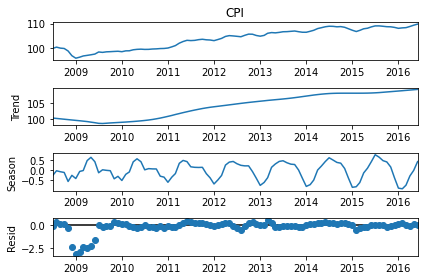

In [12]:
X = with_dt_index(develop)
stl = STL(monthly['CPI'], seasonal=13, robust=True)
res = stl.fit()
p = res.plot()

In [13]:
from statsmodels.tsa.api import SimpleExpSmoothing
monthly_fit = monthly.iloc[:-20]
monthly_eval = monthly.iloc[-20:]


forecast = STLForecast(endog=monthly_fit.CPI, model=SimpleExpSmoothing, 
                       model_kwargs=dict(initialization_method='estimated'), 
                       seasonal=13, robust=True)
forecast_res = forecast.fit()

In [14]:
forecast_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
            STL Decomposition and SimpleExpSmoothing Model Results            
==============================================================================
Dep. Variable:                   None   No. Observations:                   76
Model:             SimpleExpSmoothing   SSE                             14.373
Optimized:                       True   AIC                           -122.571
Trend:                           None   BIC                           -117.910
Seasonal:                        None   AICC                          -122.008
Seasonal Periods:                None   Date:                 Mon, 20 Sep 2021
Box-Cox:                        False   Time:                         03:19:49
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              100.05623                  l.0                 True
                                STL Configuration                                
=================================================================================
Period:                            12       Trend Length:                      21
Seasonal:                          13       Trend deg:                          1
Seasonal deg:                       1       Trend jump:                         1
Seasonal jump:                      1       Low pass:                          13
Robust:                          True       Low pass deg:                       1
---------------------------------------------------------------------------------
"""

In [15]:
monthly_eval['forecast_cpi'] = forecast_res.forecast(20)

/home/apsvieira/.cache/pypoetry/virtualenvs/meli-1mU00-x8-py3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/tmp/ipykernel_278934/1855346520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_eval['forecast_cpi'] = forecast_res.forecast(20)


In [16]:
from sklearn.metrics import (
    r2_score, mean_absolute_percentage_error, mean_squared_error)

In [17]:
plot_data = monthly_eval.reset_index()
real = vg.Chart(plot_data).mark_line().encode(
    x=vg.X('date'),
    y=vg.Y('CPI', scale=vg.Scale(domain=[95, 120])),
    color=vg.value('blue'),
)

forecast = vg.Chart(plot_data).mark_line().encode(
    x=vg.X('date'),
    y=vg.Y('forecast_cpi', scale=vg.Scale(domain=[95, 120])),
    color=vg.value('lightgrey'),
)

chart = vg.layer(real, forecast)
r2 = r2_score(plot_data['CPI'], plot_data['forecast_cpi'])
mape = mean_absolute_percentage_error(plot_data['CPI'], 
                                      plot_data['forecast_cpi'])
mse = mean_squared_error(plot_data['CPI'], plot_data['forecast_cpi'])
chart = chart.properties(width=800, height=600, 
                         title=f'CPI - Real and Forecast (R2 = {r2:.2f})')
chart = configure_title(chart)

print(f'MAPE: {mape:.4f}')
print(f'MSE: {mse:.4f}')

chart

MAPE: 0.0037
MSE: 0.2871


alt.LayerChart(...)

# A More Elaborate Look

# Relationship between PriceStats and CPI

In [18]:
regplot(develop, 'date', 'PriceStats', 'PriceStats values (with regression)', [95, 115])

alt.LayerChart(...)